In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import jsonargparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_violin_comparison
from cdi.util.analysis.eval import (compute_avg_kl_divergence,
                                    compute_avg_symmetrised_kl_divergence,
                                    compute_avg_wasserstein_distance,
                                    compute_gaussian_kl_div,
                                    compute_avg_num_var_updates_per_dim)
from cdi.trainers.trainer_base import TrainerBase
from cdi.trainers.posterior_cdi import PosteriorCDI
from cdi.util.analysis.show_frey_faces import show_examples
from cdi.data.frey_faces import FreyFacesDataset

## Analysis setup

### Global settings

In [6]:
data_name = 'fa_frey_processed'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

## Helpers

In [8]:
def merge_dicts(a, b, path=None):
    "merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

## Variational posterior analysis

### KL-divergence analysis $D_{\text{KL}}(q(x^j \mid x^{\smallsetminus j})||p(x^j \mid x^{\smallsetminus j}))$a

In [9]:
suite = {
#     'VCDI': 'fa_pretrained_svar_cdi',
    'VCDI': 'fa_pretrained_svar_cdi_const',
}
groups = [1, 2, 3, 4, 5]

#### Merged-dimensions line-plot

In [10]:
# stats = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats2 = compute_avg_kl_divergence(model1=model_name,
#                                        model2=model_name,
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_anal',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    
# #     stats[exp_name]['group'] = np.array(stats[exp_name]['group'])[:, None].repeat(3, 1) + np.array([-0.1, 0, 0.1])

#     dim0 = stats[exp_name]['test_avg_kldiv_var_truth_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
#     # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
#     stats[exp_name]['test_avg_kldiv_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].mean(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

# # Define metrics for plot
# y_metrics = ('test_avg_kldiv_var_truth',
#             'test_avg_kldiv_var_anal',
#             'test_avg_kldiv_model_truth')
# err_metrics = ('test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                'test_avg_kldiv_std_err_model_truth')
# metric_labels = ('$D_{\\mathrm{KL}}(q \\mid\\mid p_*)$',
#                  '$D_{\\mathrm{KL}}(q \\mid\\mid p_{\\boldsymbol{\\theta}})$',
#                  '$D_{\\mathrm{KL}}(p_* \\mid\\mid p_{\\boldsymbol{\\theta}})$') # (p_* \\mid\\mid p_{\\boldsymbol{\\theta}})

# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
# # axes = axes.flatten()
# ylabel = 'nats'
# xlabel = 'Missingness'

# plot_comparison(axes, stats, 
#                 x_metric_key='group',
#                 y_metric_keys=y_metrics,
#                 err_keys=err_metrics,
#                 metric_labels=metric_labels,
#                 xlabel=xlabel,
#                 ylabel=ylabel, 
#                 ylim=None,
#                 colors_instead_styles=True,
#                 x_jitter=[-0.05, 0., 0.05])

# axes.xaxis.set_ticks(groups)
# axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

# fig.tight_layout()

#### Merged-dimension violinplot

In [11]:
# stats = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats2 = compute_avg_kl_divergence(model1=model_name,
#                                        model2=model_name,
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_anal',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    
#     dim0 = stats[exp_name]['test_avg_kldiv_var_truth_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
#     # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = np.median(stats[exp_name]['test_avg_kldiv_var_truth_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = np.median(stats[exp_name]['test_avg_kldiv_model_truth_all'], axis=1)
    
# #     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
# #     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
# #     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

# for method, experiments in stats.items():
#     experiments['group2'] = experiments['group']
#     experiments['group'] = [experiments['group']]
    
    
# # Define metrics for plot
# y_metrics = ('test_avg_kldiv_var_truth_all',
#             'test_avg_kldiv_var_anal_all',
#             'test_avg_kldiv_model_truth_all')
# y_metrics_line = ('test_avg_kldiv_var_truth',
#                  'test_avg_kldiv_var_anal',
#                  'test_avg_kldiv_model_truth')
# # err_metrics = ('test_avg_kldiv_std_err_var_truth',
# #                'test_avg_kldiv_std_err_var_anal',
# #                'test_avg_kldiv_std_err_model_truth')
# metric_labels = ('$D_{KL}(q||p_*)$',
#                  '$D_{KL}(q||p_{\\theta})$',
#                  '$D_{KL}(p_*||p_{\\theta})$')

# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(9, 9))
# # fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
# #              fontsize=16)
# colors = list(plt.cm.tab10(np.arange(10)))
# axes = axes.flatten()
# for i in range(len(axes)):
#     ylabel='nats'
#     if i == 2:
#         xlabel='Missingness'
#     else:
#         xlabel=None
#     bw=None
#     width=None
# #     axes[i].set(title=f'dim({i})')
#     plot_seaborn_violin_comparison(axes[i], stats, 
#                     x_metric_key='group',
#                     y_metric_keys=(y_metrics[i],),
#                     y_metric_dim=None,
#                     metric_labels=(None,),
#                     xlabel=xlabel,
#                     ylabel=ylabel, 
#                     ylim=None,
#                     colors_instead_styles=True,
#                     colors=[colors[i]],
#                     band_width=bw,
#                     cut=0.,
#                     width=width,
#                     upper_boundaries=[2, 1.06, 1.06][i])

#     plot_comparison(axes[i], stats, 
#                     x_metric_key='group2',
#                     y_metric_keys=(y_metrics_line[i],),
#                     y_metric_dim=None,
#                     err_keys=(None,),
#                     err_metric_dim=None,
#                     metric_labels=(metric_labels[i],),
#                     xlabel=xlabel,
#                     ylabel=ylabel, 
#                     ylim=None,
#                     colors_instead_styles=True,
#                     colors=[colors[i]],
#                     legend_loc='upper left')
    
#     axes[i].xaxis.set_ticks(groups)
#     axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
#     axes[i].grid()
    
#     axes[i].set_ylim(-0.05, 1.05)

# fig.tight_layout()

In [ ]:
# print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

##### Same over one seed only

In [ ]:
# stats = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys[:1],
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats2 = compute_avg_kl_divergence(model1=model_name,
#                                        model2=model_name,
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_anal',
#                                        seeds=exp_seed_keys[:1],
#                                        groups=groups,
#                                        base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys[:1],
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    
#     dim0 = stats[exp_name]['test_avg_kldiv_var_truth_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
#     # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = np.median(stats[exp_name]['test_avg_kldiv_var_truth_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = np.median(stats[exp_name]['test_avg_kldiv_model_truth_all'], axis=1)
    
# #     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
# #     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
# #     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

# for method, experiments in stats.items():
#     experiments['group2'] = experiments['group']
#     experiments['group'] = [experiments['group']]
    
    
# # Define metrics for plot
# y_metrics = ('test_avg_kldiv_var_truth_all',
#             'test_avg_kldiv_var_anal_all',
#             'test_avg_kldiv_model_truth_all')
# y_metrics_line = ('test_avg_kldiv_var_truth',
#                  'test_avg_kldiv_var_anal',
#                  'test_avg_kldiv_model_truth')
# # err_metrics = ('test_avg_kldiv_std_err_var_truth',
# #                'test_avg_kldiv_std_err_var_anal',
# #                'test_avg_kldiv_std_err_model_truth')
# metric_labels = ('$D_{KL}(q||p_*)$',
#                  '$D_{KL}(q||p_{\\theta})$',
#                  '$D_{KL}(p_*||p_{\\theta})$')

# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(9, 9))
# # fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
# #              fontsize=16)
# colors = list(plt.cm.tab10(np.arange(10)))
# axes = axes.flatten()
# for i in range(len(axes)):
#     ylabel='nats'
#     if i == 2:
#         xlabel='Missingness'
#     else:
#         xlabel=None

# #     if i < 2:
# #         bw = 1
# #         width = 0.1
# #     else:
# #         bw = 0.3
# #         width = 0.5
    
#     bw=None
#     width=None
# #     axes[i].set(title=f'dim({i})')
#     plot_seaborn_violin_comparison(axes[i], stats, 
#                     x_metric_key='group',
#                     y_metric_keys=(y_metrics[i],),
#                     y_metric_dim=None,
#                     metric_labels=(None,),
#                     xlabel=xlabel,
#                     ylabel=ylabel, 
#                     ylim=None,
#                     colors_instead_styles=True,
#                     colors=[colors[i]],
#                     band_width=bw,
#                     cut=0.,
#                     width=width,
#                     upper_boundaries=[2, 1.06, 1.06][i])

#     plot_comparison(axes[i], stats, 
#                     x_metric_key='group2',
#                     y_metric_keys=(y_metrics_line[i],),
#                     y_metric_dim=None,
#                     err_keys=(None,),
#                     err_metric_dim=None,
#                     metric_labels=(metric_labels[i],),
#                     xlabel=xlabel,
#                     ylabel=ylabel, 
#                     ylim=None,
#                     colors_instead_styles=True,
#                     colors=[colors[i]],
#                     legend_loc='upper left')
    
#     axes[i].xaxis.set_ticks(groups)
#     axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
#     axes[i].grid()
    
#     axes[i].set_ylim(-0.05, 1.05)

# fig.tight_layout()

In [ ]:
# print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

#### Merged-dimension violinplot, only keep $\text{KL}(q \mid p^*)$ and $\text{KL}(q \mid p_\theta)$

<IPython.core.display.Javascript object>


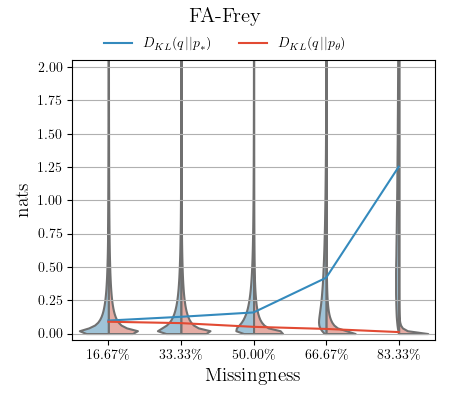

In [10]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].mean(axis=1)
    
    stats[exp_name]['test_avg_kldiv_var_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_kldiv_var_truth_all'])
    stats[exp_name]['test_avg_kldiv_var_anal_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_kldiv_var_anal_all'])
#     stats[exp_name]['test_avg_kldiv_model_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_kldiv_model_truth_all'])
    
    stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
    stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

    # Hack for plotting half-violins
    dummy = np.full((stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0], 1), 
                    fill_value=-0.2)
    stats[exp_name]['test_avg_kldiv_var_truth_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_kldiv_var_truth_all']],
                                                       axis=-1)
    stats[exp_name]['test_avg_kldiv_var_anal_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_kldiv_var_anal_all']],
                                                       axis=-1)

    stats[exp_name]['test_avg_kldiv_var_truth_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=1),
                                                            np.full(stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
                                                                    fill_value=0)],
                                                           axis=-1)
    stats[exp_name]['test_avg_kldiv_var_anal_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics1 = ('test_avg_kldiv_var_truth_all_hack',)
y_hue_key1 = 'test_avg_kldiv_var_truth_all_hack_hue'
y_metrics2 = ('test_avg_kldiv_var_anal_all_hack',)
y_hue_key2 = 'test_avg_kldiv_var_anal_all_hack_hue'
# y_metrics_line = (#'test_avg_kldiv_var_truth',
#                  'test_avg_kldiv_var_anal',
#                  'test_avg_kldiv_model_truth')
y_metrics_line = ('test_avg_kldiv_var_truth_median',
                  'test_avg_kldiv_var_anal_median',
                  #'test_avg_kldiv_model_truth_median'
                 )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                'test_avg_kldiv_std_err_model_truth')
err_metrics = (None, None)
metric_labels = ('$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4.5, 4))
colors = ['#348ABD', '#E24A33']
# colors_violin = ['#8bbfe4', '#f6b276
colors_violin = ['#95c5e1', '#f0a499' ]

ylabel='nats'
xlabel='Missingness'

bw=None
width=None
plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics1,
                y_metric_dim=None,
                y_hue_key=y_hue_key1,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=False,
                cut=0.,
                upper_boundaries=2.1)

plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics2,
                y_metric_dim=None,
                y_hue_key=y_hue_key2,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=True,
                cut=0.,
                upper_boundaries=2.1)

plot_comparison(axes, stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

    
axes.set_ylim(-0.05, 2.05)
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
axes.set_xlim(0.5, 5.5)
# axes.grid()

# fig.tight_layout()

fig.suptitle('FA-Frey', fontsize=15)

fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes.get_legend_handles_labels()

axes.legend(handles[4:], labels[4:],
            ncol=2, bbox_to_anchor=(0.5, 0.89), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [11]:
# fig.savefig('figures/fa_frey_posterior_kldiv.pdf', bbox_inches='tight')

#### Investigate conditionals that are in the tails

In [12]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base,
                                       return_params=True)

    stats[exp_name] = {**stats2}
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_means'] = stats[exp_name]['test_var_anal_m1_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_logvars'] = stats[exp_name]['test_var_anal_m1_post_logvars'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_means'] = stats[exp_name]['test_var_anal_m2_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_logvars'] = stats[exp_name]['test_var_anal_m2_post_logvars'].reshape(dim0, -1)
    

In [13]:
idx = stats['VCDI']['test_avg_kldiv_var_anal_all'].argmax(axis=-1)
print('var_mean', stats['VCDI']['test_var_anal_m1_post_means'][np.arange(5), idx])
print('var_std', np.exp(1/2*stats['VCDI']['test_var_anal_m1_post_logvars'][np.arange(5), idx]))
print('analytic_mean', stats['VCDI']['test_var_anal_m2_post_means'][np.arange(5), idx])
print('analytic_std', np.exp(1/2*stats['VCDI']['test_var_anal_m2_post_logvars'][np.arange(5), idx]))

var_mean [-0.22713055  0.8524761   0.6537143  14.620903   -2.1928449 ]
var_std [0.04595771 0.04510372 0.05323697 0.18753313 0.07840058]
analytic_mean [-0.7358118   1.2747645   1.0927111   0.16784164  0.09838098]
analytic_std [0.04097173 0.03766466 0.05408577 0.19269386 0.07809225]


### Univariate Wasserstein distance $\mathcal{W} = (\mu_1 - \mu_2)^2 + (\sigma_1 - \sigma_2)^2$

In [9]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_const',
}
groups = [1, 2, 3, 4, 5]

In [ ]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    
    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = ('test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',
            'test_avg_wass_dist_model_truth')
err_metrics = ('test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',
               'test_avg_wass_dist_std_err_model_truth')
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 '$\\mathcal{W}(p_*, p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$\\mathcal{W}$', 
                    ylim=None,
                    x_jitter=[-0.05, 0., 0.05])

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()

fig.tight_layout()

#### Merged-dimensions violinplot

<IPython.core.display.Javascript object>


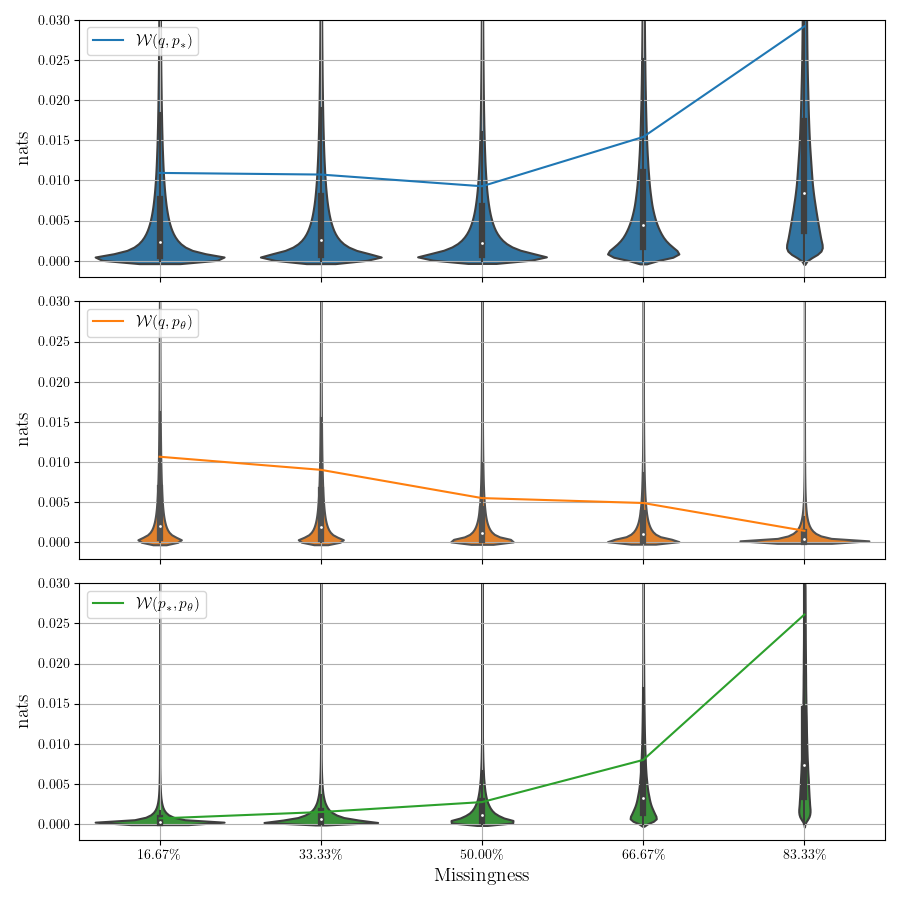

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [24]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape[0]
    stats[exp_name]['test_avg_wass_dist_var_truth_all'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_wass_dist_model_truth_all'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_wass_dist_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].mean(axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].mean(axis=-1)
    stats[exp_name]['test_avg_wass_dist_model_truth'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].mean(axis=-1)
    
    stats[exp_name]['test_avg_wass_dist_std_err_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_wass_dist_std_err_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_wass_dist_std_err_model_truth'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].std(axis=-1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = ('test_avg_wass_dist_var_truth_all',
            'test_avg_wass_dist_var_anal_all',
            'test_avg_wass_dist_model_truth_all')
y_metrics_line = ('test_avg_wass_dist_var_truth',
                 'test_avg_wass_dist_var_anal',
                 'test_avg_wass_dist_model_truth')
err_metrics = (None, None, None)
# err_metrics = ('test_avg_wass_dist_std_err_var_truth',
#                'test_avg_wass_dist_std_err_var_anal',
#                'test_avg_wass_dist_std_err_model_truth')
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 '$\\mathcal{W}(p_*, p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(9, 9))
# fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
#              fontsize=16)
colors = list(plt.cm.tab10(np.arange(10)))
axes = axes.flatten()
for i in range(len(axes)):
    ylabel='nats'
    if i == 2:
        xlabel='Missingness'
    else:
        xlabel=None

#     if i < 2:
#         bw = 1
#         width = 0.1
#     else:
#         bw = 0.3
#         width = 0.5
    
    bw=None
    width=None
#     axes[i].set(title=f'dim({i})')
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    width=width,
                    upper_boundaries=[0.04, 0.0302, 0.0302][i])

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.002, 0.03)

fig.tight_layout()

#### Merged-dimension violinplot, only keep $\mathcal{W}(q , p^*)$ and $\mathcal{W}(q , p_\theta)$

<IPython.core.display.Javascript object>


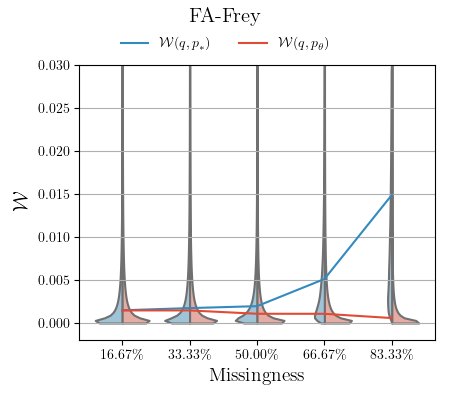

In [12]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape[0]
    stats[exp_name]['test_avg_wass_dist_var_truth_all'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_wass_dist_model_truth_all'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_wass_dist_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].mean(axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].mean(axis=-1)
#     stats[exp_name]['test_avg_wass_dist_model_truth'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].mean(axis=-1)

    stats[exp_name]['test_avg_wass_dist_var_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_wass_dist_var_truth_all'])
    stats[exp_name]['test_avg_wass_dist_var_anal_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_wass_dist_var_anal_all'])
#     stats[exp_name]['test_avg_wass_dist_model_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_wass_dist_model_truth_all'])
    
    stats[exp_name]['test_avg_wass_dist_std_err_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_wass_dist_std_err_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].std(axis=-1, ddof=1)
#     stats[exp_name]['test_avg_wass_dist_std_err_model_truth'] = stats[exp_name]['test_avg_wass_dist_model_truth_all'].std(axis=-1, ddof=1)

    # Hack for plotting half-violins
    dummy = np.full((stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape[0], 1), 
                    fill_value=-0.2)
    stats[exp_name]['test_avg_wass_dist_var_truth_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_wass_dist_var_truth_all']],
                                                       axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_wass_dist_var_anal_all']],
                                                       axis=-1)

    stats[exp_name]['test_avg_wass_dist_var_truth_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=1),
                                                            np.full(stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape,
                                                                    fill_value=0)],
                                                           axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_wass_dist_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)
    
for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics1 = ('test_avg_wass_dist_var_truth_all_hack',)
y_hue_key1 = 'test_avg_wass_dist_var_truth_all_hack_hue'
y_metrics2 = ('test_avg_wass_dist_var_anal_all_hack',)
y_hue_key2 = 'test_avg_wass_dist_var_anal_all_hack_hue'
# y_metrics = ('test_avg_wass_dist_var_truth_all',
#             'test_avg_wass_dist_var_anal_all',
#             'test_avg_wass_dist_model_truth_all')
y_metrics_line = ('test_avg_wass_dist_var_truth_median',
                 'test_avg_wass_dist_var_anal_median',
                 #'test_avg_wass_dist_model_truth_median'
                 )
err_metrics = (None, None)
# err_metrics = ('test_avg_wass_dist_std_err_var_truth',
#                'test_avg_wass_dist_std_err_var_anal',
#                'test_avg_wass_dist_std_err_model_truth')
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 #'$\\mathcal{W}(p_*, p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4.5, 4))
colors = ['#348ABD', '#E24A33']
colors_violin = ['#95c5e1', '#f0a499' ]

ylabel='$\\mathcal{W}$'
xlabel='Missingness'

bw=None
width=None
plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics1,
                y_metric_dim=None,
                y_hue_key=y_hue_key1,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=False,
                cut=0.,
                upper_boundaries=0.03)

plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics2,
                y_metric_dim=None,
                y_hue_key=y_hue_key2,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=True,
                cut=0.,
                upper_boundaries=0.03)

plot_comparison(axes, stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[4:], labels[4:], loc='upper left')
    
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
axes.set_ylim(-0.002, 0.03)
# axes.grid()

# fig.tight_layout()

fig.suptitle('FA-Frey', fontsize=15)

fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes.get_legend_handles_labels()

axes.legend(handles[4:], labels[4:],
            ncol=2, bbox_to_anchor=(0.5, 0.89), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [13]:
# fig.savefig('figures/fa_frey_posterior_wass.pdf', bbox_inches='tight')

#### Investigate conditionals that are in the tails

In [26]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base,
                                       return_params=True)

    stats[exp_name] = {**stats2}
    
    dim0 = stats[exp_name]['test_avg_wass_dist_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_wass_dist_var_anal_all'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_means'] = stats[exp_name]['test_var_anal_m1_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_logvars'] = stats[exp_name]['test_var_anal_m1_post_logvars'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_means'] = stats[exp_name]['test_var_anal_m2_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_logvars'] = stats[exp_name]['test_var_anal_m2_post_logvars'].reshape(dim0, -1)
    

In [32]:
idx = stats['VCDI']['test_avg_wass_dist_var_anal_all'].argmax(axis=-1)
print('var_mean', stats['VCDI']['test_var_anal_m1_post_means'][np.arange(5), idx])
print('var_std', np.exp(1/2*stats['VCDI']['test_var_anal_m1_post_logvars'][np.arange(5), idx]))
print('analytic_mean', stats['VCDI']['test_var_anal_m2_post_means'][np.arange(5), idx])
print('analytic_std', np.exp(1/2*stats['VCDI']['test_var_anal_m2_post_logvars'][np.arange(5), idx]))

var_mean [ 1.9609176  1.0882949 -0.5602503  2.0421374 -3.564616 ]
var_std [0.30910647 0.31419435 0.28022075 0.15103363 0.12814851]
analytic_mean [ 2.8100007   2.0550175   0.30951098  0.10305728 -0.7208869 ]
analytic_std [0.29089925 0.3141083  0.28360948 0.1514044  0.1282276 ]


## KL-div evaluated on generated data

In [82]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_eval_gen',
}
groups = [1, 2, 3, 4, 5]

<IPython.core.display.Javascript object>


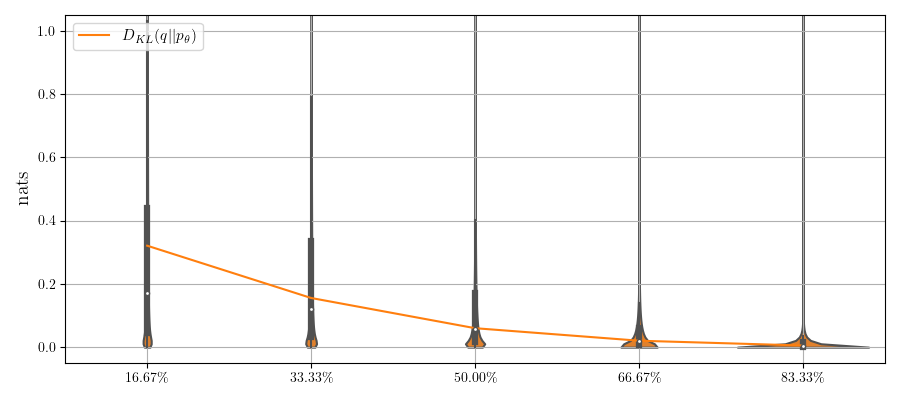

No handles with labels found to put in legend.


In [83]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
# fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
#              fontsize=16)
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    if i == 2:
        xlabel='Missingness'
    else:
        xlabel=None
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.06)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

In [84]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[175.96867 164.33597 232.02032 250.44447 425.2189 ]


The KL-div on generated data from $p_\theta$ have even larger tails than when evaluated on samples from $p_*$. The intuition here is that $p_\theta$ is fitted to $p_*$ by minimizing $\text{KL}(p_*\mid\mid p_\theta)$, which is mass-covering, i.e. it will likely be more spread-out than $p_*$ due to sample-size. Now the $q$ is fitted to $p_\theta$ such with $\text{KL}(q \mid\mid p_\theta)$, which is mode-seeking, i.e. it underestimates the variance. The inputs to the conditional models $q$ are samples from the $p_*$ and $q$, which are both less spread-out than $p_\theta$, so at training time the models for $q$ might not see as input samples that are as much spread-out as samples from $p_\theta$.

## KL-div evaluated on model trained with regularization

In [74]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_reg',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


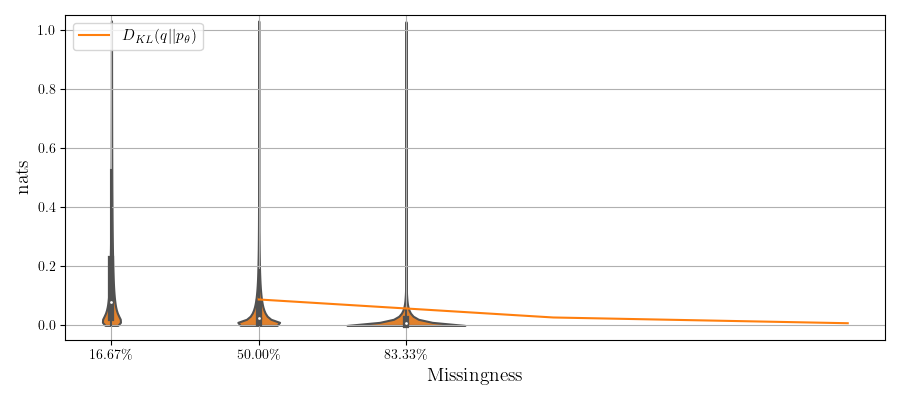

No handles with labels found to put in legend.


In [75]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [np.arange(len(experiments['group']))]
#     experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.03)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(np.arange(len(groups)))
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

In [68]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[50.173275 16.79129  93.58876 ]


## KL-div trained on larger dataset

Note, 83% failed at K-scheduling.

In [72]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_large',
}
groups = [1, 3]

<IPython.core.display.Javascript object>


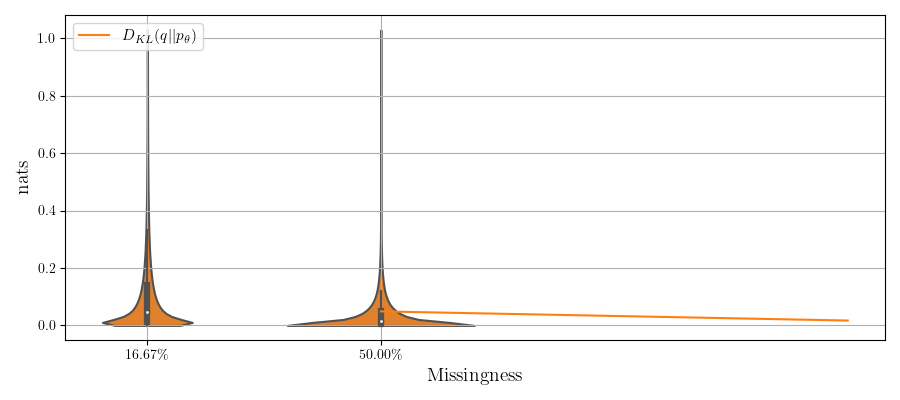

No handles with labels found to put in legend.


In [73]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [np.arange(len(experiments['group']))]
#     experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.03)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(np.arange(len(groups)))
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
#     axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

With larger dataset the median seems to decrease - a good sign. But the "outliers" are still there.

In [71]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[18.34681  34.226875]


## KL-div with varying K

### K=1

In [100]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_k1',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


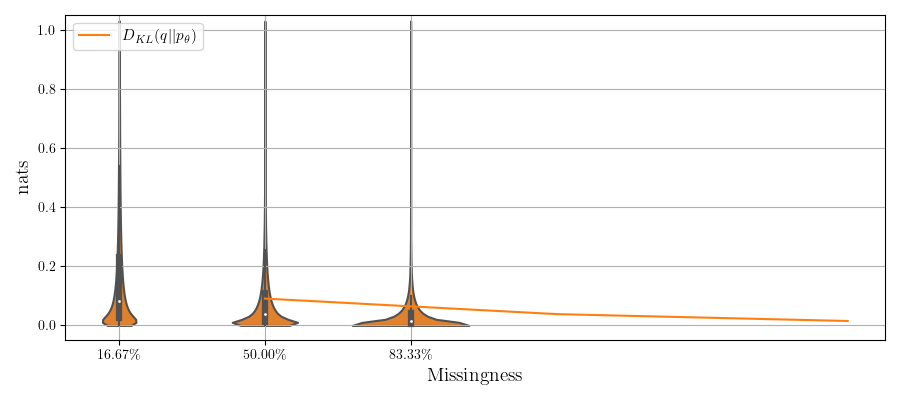

No handles with labels found to put in legend.


In [101]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [np.arange(len(experiments['group']))]
#     experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.03)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(np.arange(len(groups)))
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

In [102]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[ 52.811813  16.869421 425.12473 ]


In [104]:
print(stats['VCDI']['test_avg_kldiv_var_anal'])

[0.09079096 0.03825265 0.01495928]


### K=5

In [105]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_k5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


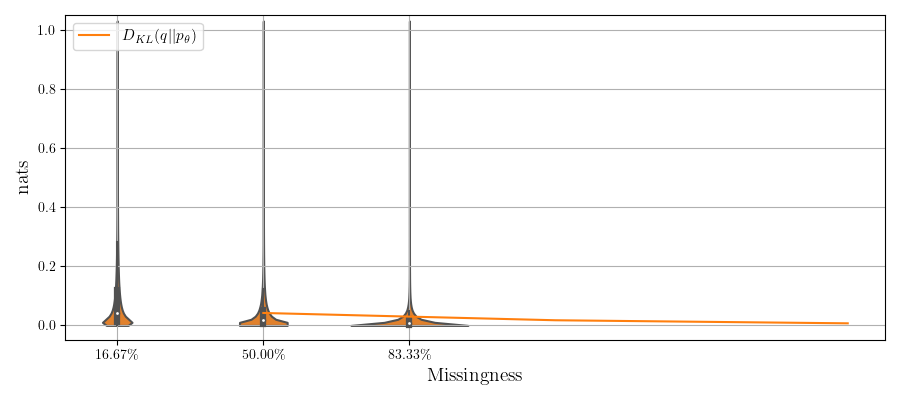

No handles with labels found to put in legend.


In [106]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [np.arange(len(experiments['group']))]
#     experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.03)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(np.arange(len(groups)))
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

In [107]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[49.843956 22.09486   8.234066]


In [108]:
print(stats['VCDI']['test_avg_kldiv_var_anal'])

[0.04211539 0.01746398 0.00709137]


### K=10

In [109]:
suite = {
    'VCDI': 'fa_pretrained_svar_cdi_k10',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


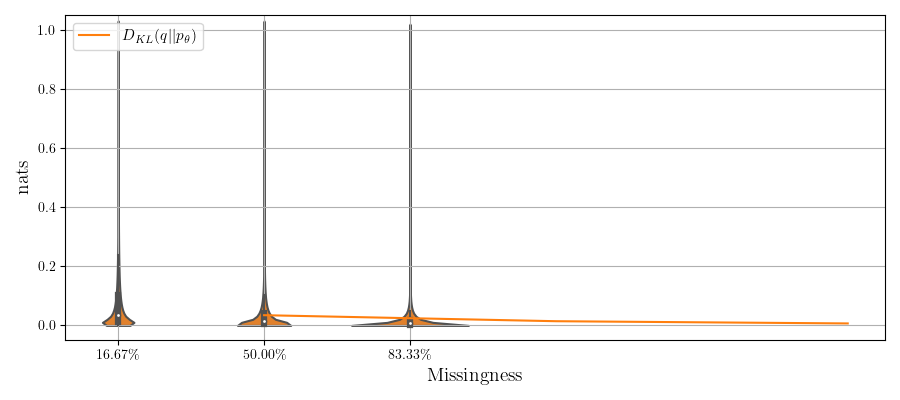

No handles with labels found to put in legend.


In [110]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
#     stats1 = compute_avg_kl_divergence(model1=model_name,
#                                        model2='fa_ground_truth_cdi',
#                                        model1_posterior_key='var',
#                                        model2_posterior_key='anal',
#                                        out_key='var_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
#     stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
#                                        model2=model_name,
#                                        model1_posterior_key='anal',
#                                        model2_posterior_key='anal',
#                                        out_key='model_truth',
#                                        seeds=exp_seed_keys,
#                                        groups=groups,
#                                        base_path=log_path_base)

#     stats[exp_name] = {**stats1, **stats2, **stats3}
    stats[exp_name] = stats2
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
#     stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
#     stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
#     stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].median(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats[exp_name]['test_avg_kldiv_var_anal_all'], axis=1)
#     stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].median(axis=1)
    
#     stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
#     stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [np.arange(len(experiments['group']))]
#     experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            #'test_avg_kldiv_model_truth_all'
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 #'test_avg_kldiv_model_truth'
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal',
#                #'test_avg_kldiv_std_err_model_truth'
#                 )
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
colors = list(plt.cm.tab10(np.arange(10)))[1:]
axes = [axes]
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=1.03)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=None,
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(np.arange(len(groups)))
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
#     axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()
    
    axes[i].set_ylim(-0.05, 1.05)

fig.tight_layout()

In [111]:
print(stats['VCDI']['test_avg_kldiv_var_anal_all'].max(axis=-1))

[60.61165  26.142355  8.23686 ]


In [112]:
print(stats['VCDI']['test_avg_kldiv_var_anal'])

[0.03456861 0.01424152 0.00671643]


### Compare K=1, K=5, K=5

In [17]:
suite = {
    'K=1': 'fa_pretrained_svar_cdi_k1',
    'K=5': 'fa_pretrained_svar_cdi_k5',
    'K=10': 'fa_pretrained_svar_cdi_k10',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


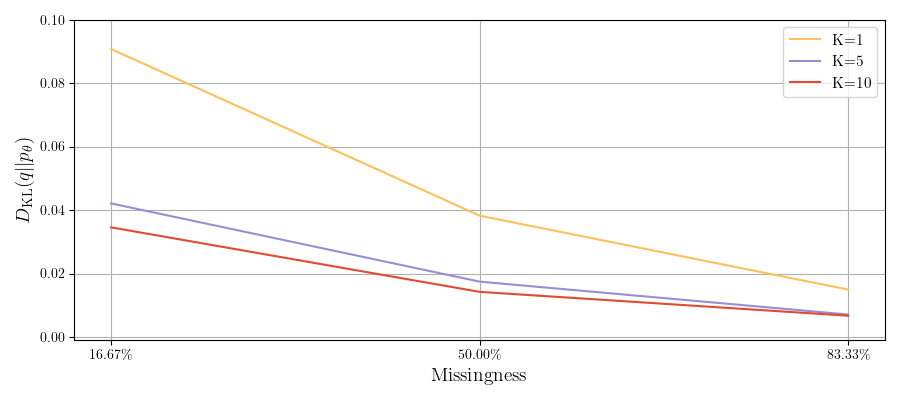

In [23]:
stats = defaultdict(dict)
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    dim0 = stats2['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats2['test_avg_kldiv_var_anal_all'].reshape(dim0, -1), axis=1)
    stats[exp_name]['group'] = stats2['group']
    
    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            )
y_metrics_line = (#'test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                  )
# err_metrics = (#'test_avg_kldiv_std_err_var_truth',
#                'test_avg_kldiv_std_err_var_anal'
#                 )
# metric_labels = (#'$D_{KL}(q||p_*)$',
#                  '$D_{KL}(q||p_{\\theta})$',
#                 )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
ylabel='$D_{\\mathrm{KL}}(q||p_{\\theta})$'
xlabel='Missingness'

colors = ['#FBC15E', '#988ED5', '#E24A33', ]

plot_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=(None,),
                err_metric_dim=None,
                metric_labels=None,
                xlabel=xlabel,
                ylabel=ylabel, 
                colors = colors,
                ylim=None)
    
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
# axes.grid()

axes.set_ylim(-0.001, 0.1)

fig.tight_layout()

In [24]:
fig.savefig('figures/fa_frey_posterior_KL_compare_num_chains.pdf', bbox_inches='tight')

## Imputations

In [9]:
original_dataset = FreyFacesDataset('../../data', preprocess=False, test=True, generated='FA')

Using test set. frey_generated_test.mat


In [10]:
gibbs_path = f'{log_path_base}/{{}}/{{}}/{{}}/evaluations/tensors/gibbs_samples_test.npz'

### 16%

In [11]:
model = 'fa_pretrained_svar_cdi_const'
exp_seed_key = exp_seed_keys[0]
group = 1

data = np.load(gibbs_path.format(group, model, exp_seed_key), allow_pickle=True)
X_postprocessed = original_dataset.postprocess(data['X'])

In [12]:
diverged = np.where(np.isnan(np.min(data['X'], axis=-1)))[0]
print(diverged)
print(diverged.shape)

[]
(0,)


<IPython.core.display.Javascript object>


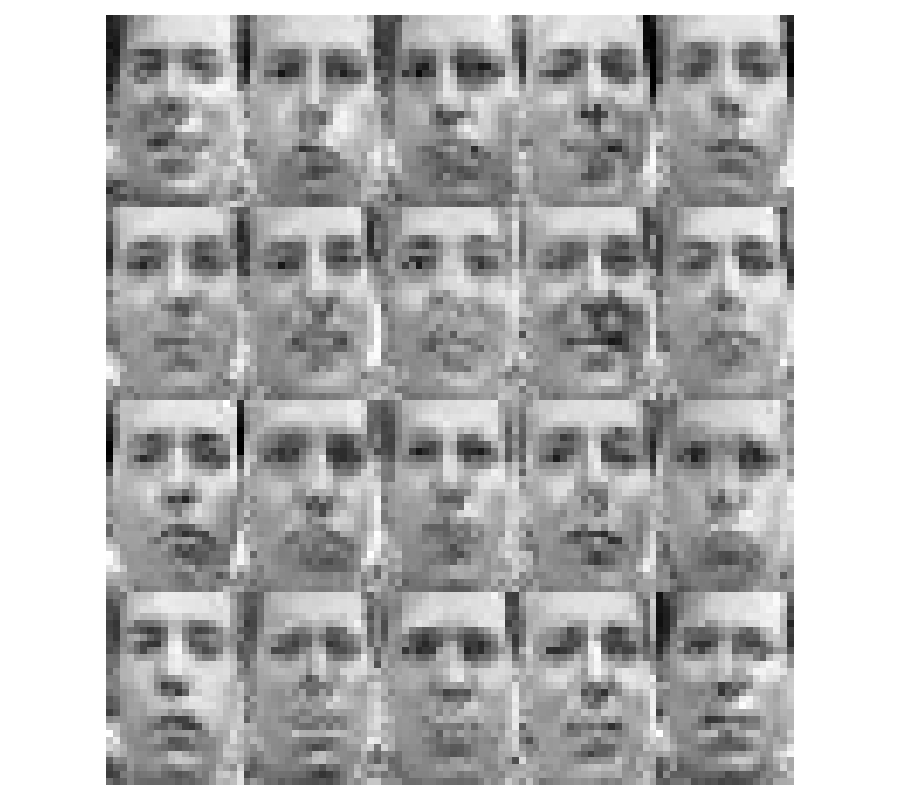

In [13]:
# Show examples
ids = np.random.choice(np.arange(len(X_postprocessed)), 20)
show_data = np.clip(X_postprocessed, 0, 1)[ids]
mask = data['M'][ids]
show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))

<IPython.core.display.Javascript object>


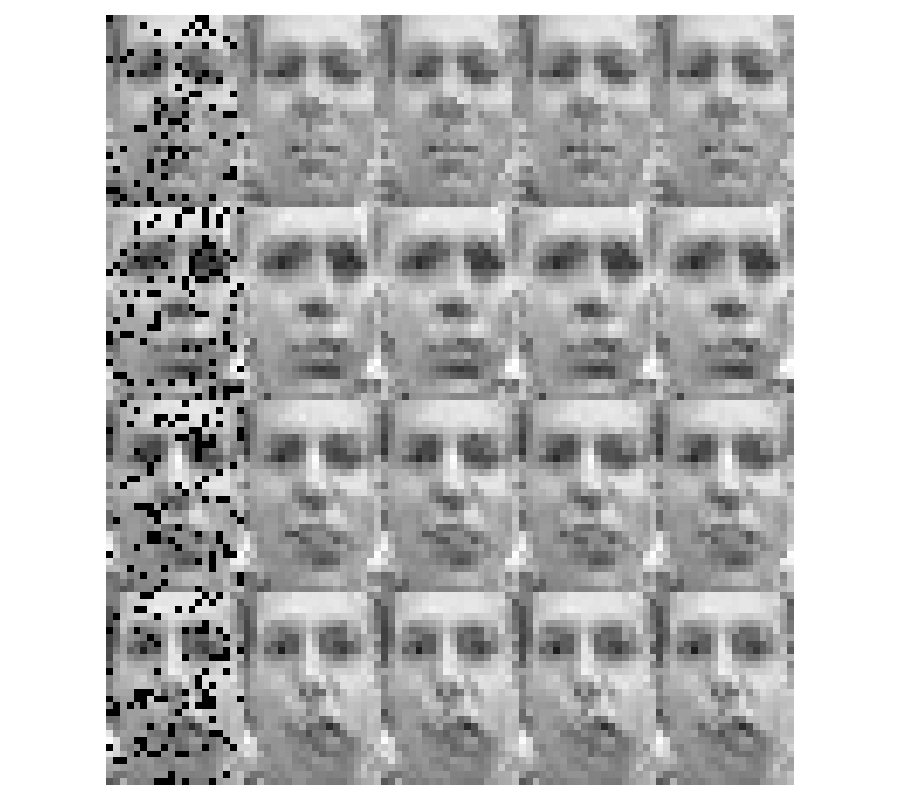

In [14]:
idx = np.sort(np.random.choice(np.unique(data['orig_I']), 5, replace=False))
show_data = []
mask = []
for i in idx:
    # Select image indices for particular original image I
    idx_i = np.random.choice(np.where(data['orig_I'] == i)[0], 5, replace=False)
    show_data.append(X_postprocessed[idx_i])
    mask.append(data['M'][idx_i])
    
    # Mask first, to see where the data is missing
    show_data[-1][0] *= mask[-1][0]
show_data = np.concatenate(show_data)
mask = np.concatenate(mask)

show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))

### 50%

In [15]:
model = 'fa_pretrained_svar_cdi'
exp_seed_key = exp_seed_keys[0]
group = 3

data = np.load(gibbs_path.format(group, model, exp_seed_key), allow_pickle=True)
X_postprocessed = original_dataset.postprocess(data['X'])

In [16]:
diverged = np.where(np.isnan(np.min(data['X'], axis=-1)))[0]
print(diverged)
print(diverged.shape)

[]
(0,)


<IPython.core.display.Javascript object>


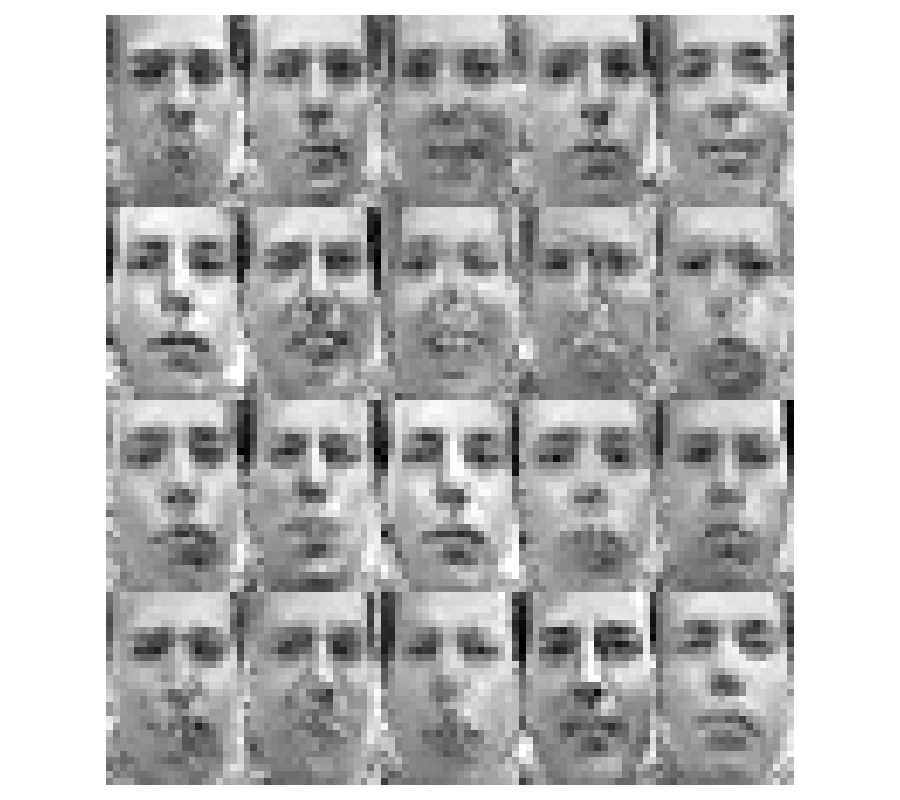

In [17]:
# Show examples
ids = np.random.choice(np.arange(len(X_postprocessed)), 20)
show_data = np.clip(X_postprocessed, 0, 1)[ids]
mask = data['M'][ids]
show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))

<IPython.core.display.Javascript object>


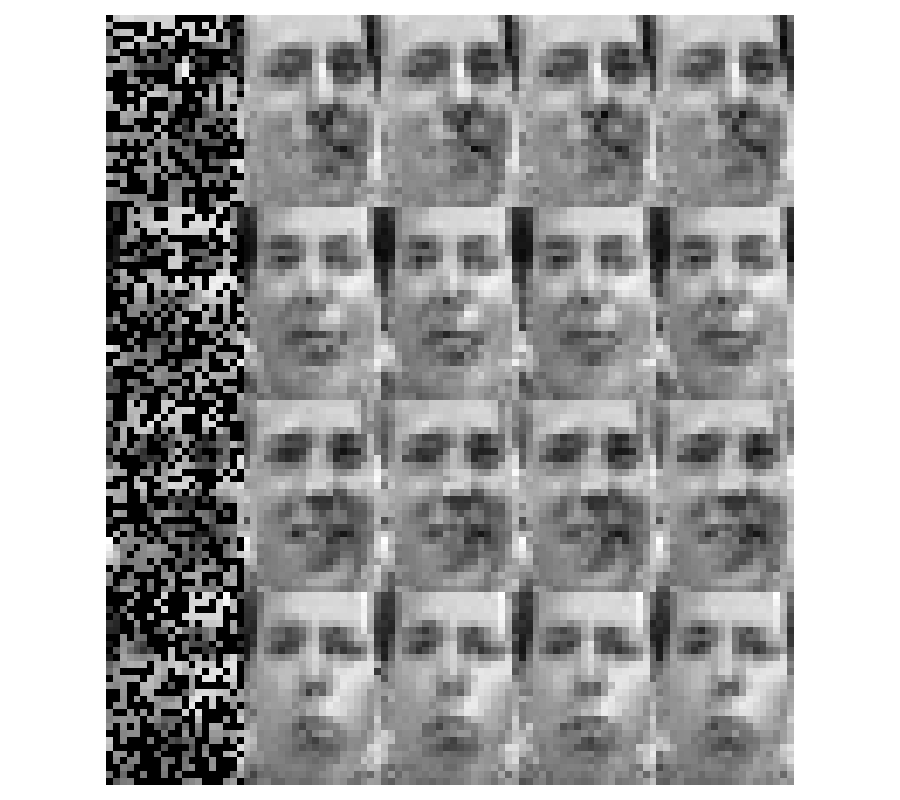

In [18]:
idx = np.sort(np.random.choice(np.unique(data['orig_I']), 5, replace=False))
show_data = []
mask = []
for i in idx:
    # Select image indices for particular original image I
    idx_i = np.random.choice(np.where(data['orig_I'] == i)[0], 5, replace=False)
    show_data.append(X_postprocessed[idx_i])
    mask.append(data['M'][idx_i])
    
    # Mask first, to see where the data is missing
    show_data[-1][0] *= mask[-1][0]
show_data = np.concatenate(show_data)
mask = np.concatenate(mask)

show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))

### 83%

In [19]:
model = 'fa_pretrained_svar_cdi'
exp_seed_key = exp_seed_keys[0]
group = 5

data = np.load(gibbs_path.format(group, model, exp_seed_key), allow_pickle=True)
X_postprocessed = original_dataset.postprocess(data['X'])

In [20]:
X_postprocessed.shape

(30000, 560)

In [21]:
diverged = np.where(np.isnan(np.min(data['X'], axis=-1)))[0]
print(diverged)
print(diverged.shape)

[ 1469  5571  5577  5910  5911  5912  5913  5914  5915  5916  5917  5918
  5919  7192  7194  7195  7199 10134 10170 10171 10172 10174 10176 10179
 11521 11528 12515 12516 12519 12540 12546 12548 12549 13771 13774 17260
 17261 17262 17263 17264 17265 17266 17267 17268 17269 17934 17937 18140
 18141 18142 18143 18144 18145 18146 18147 18148 18149 18360 18366 18367
 18368 19052 19053 19058 20160 20970 20971 20972 20973 20974 20975 20976
 20977 20978 20979 23560 23561 23562 23563 23564 23565 23566 23567 23569
 26290 29940]
(86,)


<IPython.core.display.Javascript object>


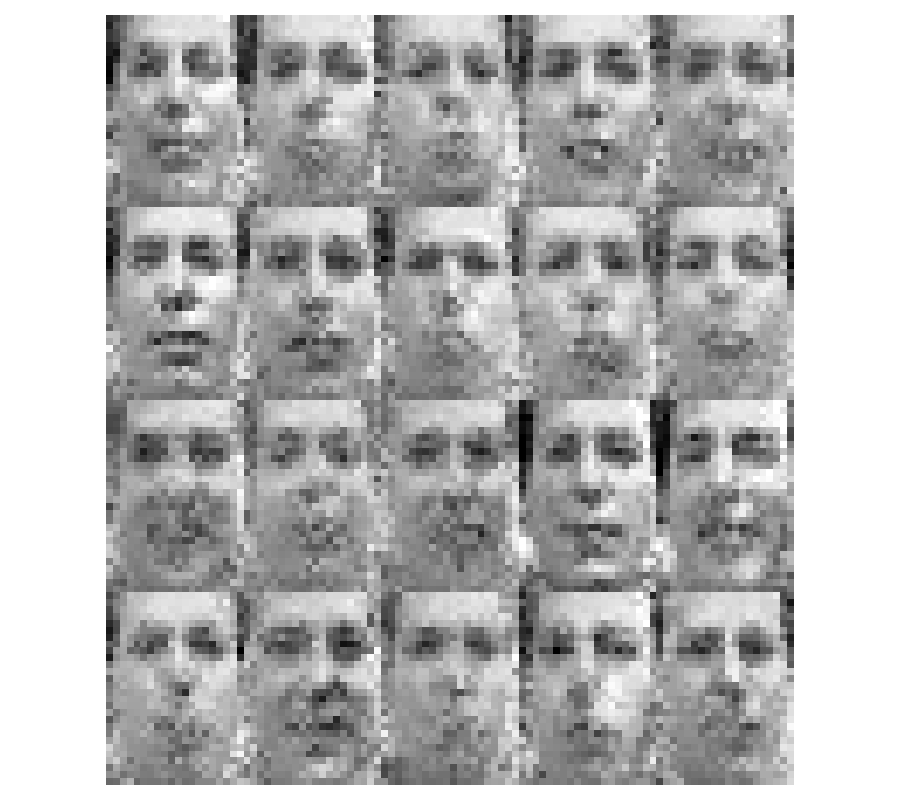

In [22]:
# Show examples
ids = np.random.choice(np.arange(len(X_postprocessed)), 20)
show_data = np.clip(X_postprocessed, 0, 1)[ids]
mask = data['M'][ids]
show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))

<IPython.core.display.Javascript object>


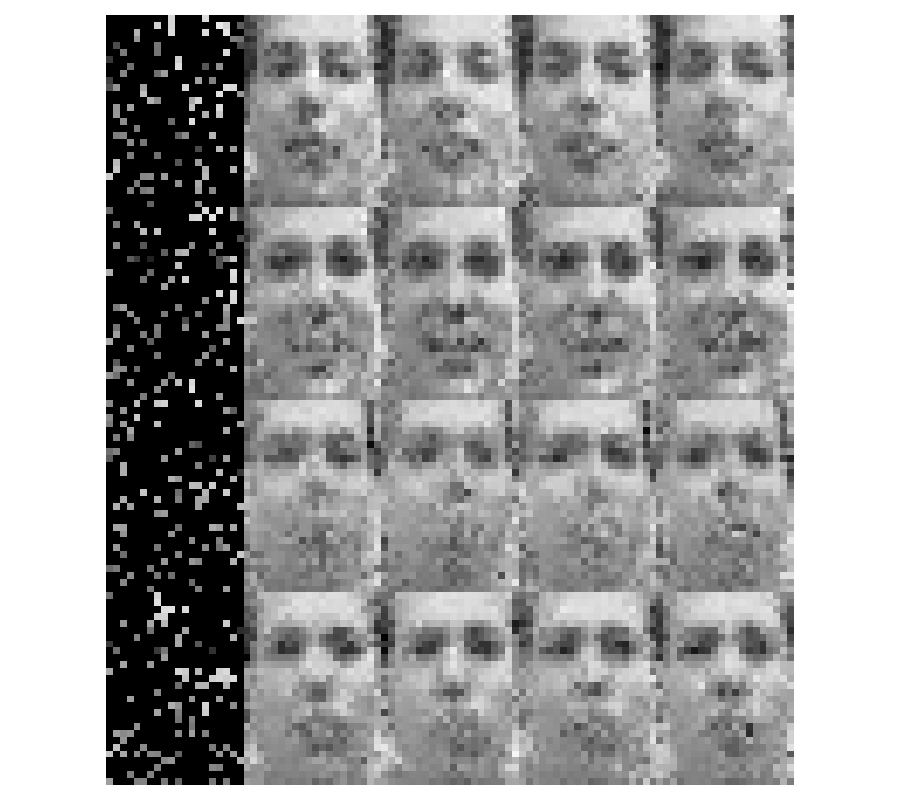

In [23]:
idx = np.sort(np.random.choice(np.unique(data['orig_I']), 5, replace=False))
show_data = []
mask = []
for i in idx:
    # Select image indices for particular original image I
    idx_i = np.random.choice(np.where(data['orig_I'] == i)[0], 5, replace=False)
    show_data.append(X_postprocessed[idx_i])
    mask.append(data['M'][idx_i])
    
    # Mask first, to see where the data is missing
    show_data[-1][0] *= mask[-1][0]
show_data = np.concatenate(show_data)
mask = np.concatenate(mask)

show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False, figsize=(9, 8))